Okay this is going to be the python which converts the stitched tiff into an anorthite content map

Basic principle

import profile files
find relevant profiles (this may end up being manual)
find profile start and end points (this will definitely be manual)
use start and end points to create mapping of stage x-stage y to tiff x tiff y
Take half of the data. Find its anorthite content and BSE intensity
Use that to create a BSE -> An function
Test that function on the other half of the data
Apply that function to the tif to generate an image coloured by anorthite content


In [567]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from PIL import Image
from IPython.display import Audio
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
#from sklearn.model_selection import train_test_split
#from sklearn.neural_network import MLPRegressor
#import warnings

sound_file = './Eldritch_Blast.wav'

In [568]:
image = np.array(plt.imread('John1_stitched_high_res.png'))
guidelines = 0
if guidelines == 1:
    for i in range(int(np.floor(image.shape[1]/10))):
        if i/100 == np.floor(i/100):
            image[::,10*i] = 1
        elif i/10 == np.floor(i/10):
            image[::,(10*i)] = 0.5
        else:
            image[::,(10*i)] = 0
        
    for j in range(int(np.floor(image.shape[0]/10))):
        if j/100 == np.floor(j/100):
            image[10*j,::] = 1
        elif j/10 == np.floor(j/10):
            image[(10*j),::] = 0.5
        else:
            image[(10*j),::] = 0
#plt.imshow(image)

#image = draw_marker(7085,8335,2,image)
#image = draw_marker(1275,625,2,image)
to_save = Image.fromarray(image)
to_save.save('John1_gridlines_check.tif')

In [569]:
np.floor(image.shape[0]/10)

1017.0

In [570]:
raw_probe_data = pd.read_csv('./Mapping data/John1_profiles_cleaned.csv')
row_cleaned = raw_probe_data[0:260] #For some reason there were three extra rows of nans and 2 columns
column_cleaned = row_cleaned.iloc[:,0:14]
probe_data = column_cleaned

In [571]:
#List of points being used for the calibration in the form (x,y), it is crucial that these are written in the same order in both lists
#stage_calibration_points = np.array([(13310,33553),(13438,21243),(11160,23249),(15397,22668),(11507,22382)])
#image_calibration_points = np.array([(7085,8335),(1275,625),(3675,870),(775,2485),(3022,476)])

stage_calibration_points = np.array([(13310,33553),(13438,21243),(11160,23249),(15397,22668)])
image_calibration_points = np.array([(7085,8335),(1275,625),(3675,870),(775,2485)])

In [572]:
stage_profile_1 = stage_calibration_points[1]-stage_calibration_points[0]
stage_profile_2 = stage_calibration_points[3]-stage_calibration_points[2]
stage_angle = np.arccos(np.dot(stage_profile_1, stage_profile_2)/(np.linalg.norm(stage_profile_1)*np.linalg.norm(stage_profile_1)))
print(stage_angle)
image_profile_1 = image_calibration_points[1]-image_calibration_points[0]
image_profile_2 = image_calibration_points[3]-image_calibration_points[2]
image_angle = np.arccos(np.dot(image_profile_1, image_profile_2)/(np.linalg.norm(image_profile_1)*np.linalg.norm(image_profile_1)))
print(image_angle)

1.5200036556977325
1.523597038160226


In [573]:
#This weirdness is strange but necessary for the optimiser
stage_cal_points_for_opt = []
image_cal_points_for_opt = []

for i in range(len(stage_calibration_points)):
    stage_cal_points_for_opt.append(stage_calibration_points[i][0])
    stage_cal_points_for_opt.append(stage_calibration_points[i][1])
    image_cal_points_for_opt.append(image_calibration_points[i][0])
    image_cal_points_for_opt.append(image_calibration_points[i][1])

In [549]:
image = np.array(plt.imread('John1_stitched_high_res.png'))

probe_x_list = probe_data.iloc[:,9]
#print(probe_x_list[0]) #for checking that the right column was selected
probe_y_list = probe_data.iloc[:,10]
probe_points = []
for i in range(len(probe_data.iloc[:,9])):
    probe_points.append((probe_data.iloc[i,9], probe_data.iloc[i,10]))
    #print(i, probe_points[i])
probe_points = np.array(probe_points)
#probe_y_list[0]
anorthite_list = (probe_data.iloc[:,4]/40.078)/((probe_data.iloc[:,4]/40.078)+(probe_data.iloc[:,1]/22.990)+(probe_data.iloc[:,6]/39.098))
parameter_bundle = curvefit_parameter_bundle
probe_points_placed = transformer(probe_points, parameter_bundle[0], parameter_bundle[1], parameter_bundle[2], parameter_bundle[3])
show_points = 0
if show_points == 1:
    
    #print(probe_points_placed)
    for i in range(len(probe_points_placed)):
        draw_marker(int(probe_points_placed[i][0]), int(probe_points_placed[i][1]),4,image)
    for i in range(len(image_calibration_points)):
        draw_marker(int(image_calibration_points[i][0]), int(image_calibration_points[i][1]),4,image)
image_boosted = image *255
to_save = image_boosted.astype(np.uint8)
print(np.max(to_save))
to_save = Image.fromarray(to_save)
to_save.save('John1_curve_4points_png_test.png')

255


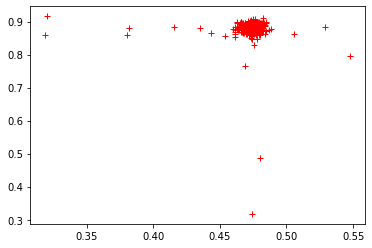

In [577]:
search_size = 2
intensity_list = []
for i in range(len(probe_points_placed)):
    #print(probe_points_placed[i][0],' ',probe_points_placed[i][1])
    intensity_list.append(get_brightness(int(probe_points_placed[i][0]),int(probe_points_placed[i][1]), search_size))
#xlim=[0.3,0.6], ylim=[0.8,0.9]
fig, ax = plt.subplots(1,1)
intensity_list = np.array(intensity_list)
ax.plot(intensity_list,anorthite_list , 'r+')
#ax.set_xlim(0.45*255,0.5*255)
#ax.set_ylim(0.8,0.93)
plt.show()

In [575]:
for i in range(len(intensity_list)):
    print(intensity_list[i], ',', anorthite_list[i])

0.5475242 , 0.7957421140671793
0.47524223 , 0.8610115121475637
0.4669566 , 0.8967952162988423
0.46746013 , 0.8953740227313302
0.48142213 , 0.8898618309441411
0.4745861 , 0.8958689756122059
0.47888914 , 0.8893052189440778
0.48220035 , 0.8959142868001949
0.48374152 , 0.8873196238585304
0.4814832 , 0.8967286459894764
0.4814832 , 0.8853610342154686
0.47687495 , 0.8929849375375206
0.4793469 , 0.8784663863373033
0.47943845 , 0.8653693864245644
0.47904173 , 0.8579747987982318
0.47374687 , 0.850987522675457
0.4751812 , 0.8785009167931062
0.48250553 , 0.8728193077765598
0.47449455 , 0.856850348183688
0.48003358 , 0.8624564376770951
0.47437248 , 0.8889692896892731
0.47400627 , 0.878512867415377
0.4800641 , 0.8855556319041891
0.4790112 , 0.8959930709987899
0.4846418 , 0.8981685325885076
0.47795835 , 0.8949882888737517
0.4822919 , 0.8968435941375865
0.4839704 , 0.8615076576295108
0.47672236 , 0.8774701320840231
0.4764477 , 0.8689637075956221
0.47351795 , 0.8695856989715427
0.47296864 , 0.869904131

In [547]:
def analytic_calibrator(stage_point_1, stage_point_2, image_point_1, image_point_2):

    #Transforms the stage coordinates to image coordinates based on exactly two points
    
    #Set these values

    #for John1
    stage_start = np.array(stage_point_1) #These can be any two points for which the stage coordinates are known
    stage_end = np.array(stage_point_2) #In the form (x,y) which is probably technically suboptimal but is definitely easier to read
    image_start = np.array(image_point_1) #These must be the same two points on the image
    image_end = np.array(image_point_2)
    
    #Do not touch
    
    #Transformation we want is distinctly stage coordinates -> image coordinates
    
    #We do this in three steps, taking advantage of the knowledge that both coordinate systems are square grids
    
    stage_calibration_vector = stage_end - stage_start #Our goal is to transform this stage vector into the image vector while preserving the square-gridness
    image_calibration_vector = image_end - image_start #This tranformation should then be able to be applied to other points 
    
    stage_cal_length = np.sqrt(stage_calibration_vector[0]**2 + stage_calibration_vector[1]**2)
    image_cal_length = np.sqrt(image_calibration_vector[0]**2 + image_calibration_vector[1]**2)
    stage_cal_normalised = np.array([(stage_calibration_vector[0]/stage_cal_length),(stage_calibration_vector[1]/stage_cal_length)])
    image_cal_normalised = np.array([(image_calibration_vector[0]/image_cal_length),(image_calibration_vector[1]/image_cal_length)])
    stage_to_image_scale = image_cal_length/stage_cal_length
    #print(stage_to_image_scale)
    #print(stage_calibration_vector)
    #print(image_calibration_vector)
    
    theta_from_cos = np.arccos((stage_cal_normalised[0]*image_cal_normalised[0]) + (stage_cal_normalised[1]*image_cal_normalised[1]))
    #print(stage_cal_normalised)
    #print(image_cal_normalised)
    #print(theta_from_cos)
    theta = np.pi + np.arcsin((image_cal_normalised[1]-stage_cal_normalised[1]*np.cos(theta_from_cos))/stage_cal_normalised[0]) #There definitely exists a better way to do this but it works
    
    return stage_to_image_scale, theta, image_start[0], image_start[1]
    
    
def transformer(probe_points, stage_to_image_scale, theta, x_offset, y_offset):
    
    #probe_x_list = []
    #probe_y_list = []
    #for i in range(len(probe_points)):
        #probe_x_list.append(probe_points[i][0])
        #probe_y_list.append(probe_points[i][1])
        
    #Now onto the actual transformation
    probe_x_centred = probe_points[:,0] - stage_calibration_points[0][0]
    probe_y_centred = probe_points[:,1] - stage_calibration_points[0][1]
    #print(probe_x_centred)
    #plt.plot(probe_x_centred, probe_y_centred, 'r+')   
    
    probe_x_scaled = probe_x_centred * stage_to_image_scale
    probe_y_scaled = probe_y_centred * stage_to_image_scale
    
    #plt.plot(probe_x_scaled, probe_y_scaled, 'r+')
    
    probe_x_rotated = probe_x_scaled*np.cos(theta) + probe_y_scaled*np.sin(theta)
    probe_y_rotated = probe_x_scaled*np.sin(theta) - probe_y_scaled*np.cos(theta)
    
    #plt.plot(probe_x_rotated, probe_y_rotated, 'r+')
    
    probe_x_placed = np.round(probe_x_rotated) + np.round(x_offset)
    probe_y_placed = np.round(probe_y_rotated) + np.round(y_offset)
    
    #plt.plot(probe_x_placed, probe_y_placed, 'r+')
    
    probe_points_placed = []
    for i in range(len(probe_points)):
        #probe_points_placed.append((probe_x_placed[i], probe_y_placed[i],probe_x_placed[i], probe_y_placed[i],probe_y_placed[i]))
        probe_points_placed.append((probe_x_placed[i], probe_y_placed[i]))
    probe_points_placed = np.array(probe_points_placed)    
    
    #plt.plot(probe_points_placed[:,0],probe_points_placed[:,1], 'r+')
    
    return probe_points_placed


In [490]:
def transformer_for_opt(optimiser_points, stage_to_image_scale, theta, x_offset, y_offset):
    
    probe_x_list = []
    probe_y_list = []
    for i in range(int(len(optimiser_points)/2)):
        probe_x_list.append(optimiser_points[2*i])
        probe_y_list.append(optimiser_points[(2*i)+1])
        
    #Now onto the actual transformation
    probe_x_centred = probe_x_list - stage_calibration_points[0][0]
    probe_y_centred = probe_y_list - stage_calibration_points[0][1]
    #print(probe_x_centred)
    #plt.plot(probe_x_centred, probe_y_centred, 'r+')   
    
    probe_x_scaled = probe_x_centred * stage_to_image_scale
    probe_y_scaled = probe_y_centred * stage_to_image_scale
    
    #plt.plot(probe_x_scaled, probe_y_scaled, 'r+')
    
    probe_x_rotated = probe_x_scaled*np.cos(theta) + probe_y_scaled*np.sin(theta)
    probe_y_rotated = probe_x_scaled*np.sin(theta) - probe_y_scaled*np.cos(theta)
    
    #plt.plot(probe_x_rotated, probe_y_rotated, 'r+')
    
    probe_x_placed = np.round(probe_x_rotated) + x_offset
    probe_y_placed = np.round(probe_y_rotated) + y_offset
    
    #plt.plot(probe_x_placed, probe_y_placed, 'r+')
    
    probe_points_placed = []
    for i in range(int(len(optimiser_points)/2)):
        #probe_points_placed.append((probe_x_placed[i], probe_y_placed[i],probe_x_placed[i], probe_y_placed[i],probe_y_placed[i]))
        probe_points_placed.append(probe_x_placed[i])
        probe_points_placed.append(probe_y_placed[i])
    probe_points_placed = np.array(probe_points_placed)    
    
    #plt.plot(probe_points_placed[:,0],probe_points_placed[:,1], 'r+')
    
    return probe_points_placed

In [410]:
#probe_points[:,0]
#transformer(probe_points, analytic_parameter_bundle[0], analytic_parameter_bundle[1], analytic_parameter_bundle[2], analytic_parameter_bundle[3])

In [511]:
def statistical_calibrator():
    
    #Transforms the stage coordinates to image coordinates with the same methodology as above
    #but finds the parameters for the transformation statistically using as many points as have been supplied
    

    
    
    #Find starting parameters, since I already have an approximate method for doing this, I may as well start the search off in very nearly the "right place" and search a relatively narrow range
    
    analytic_parameter_bundle = analytic_calibrator(stage_calibration_points[0], stage_calibration_points[1], image_calibration_points[0], image_calibration_points[1])
    max_stage_to_image_scale = analytic_parameter_bundle[0]*2 #This should be easily large enough in each direction and scales
    min_stage_to_image_scale = analytic_parameter_bundle[0]*-2 #in case in future this is used in a context with a very different scale factor
    max_theta = analytic_parameter_bundle[1] + (np.pi/6) #Sixty degrees of play ought to be enough
    min_theta = analytic_parameter_bundle[1] - (np.pi/6)
    #max_x_centring = (analytic_parameter_bundle[2]*1.1) + 100*np.sign(analytic_parameter_bundle[2]) #This is less obvious
    #min_x_centring = (analytic_parameter_bundle[2]*0.9) - 100*np.sign(analytic_parameter_bundle[2]) #but should work for most cases
    #max_y_centring = (analytic_parameter_bundle[3]*1.1) + 100*np.sign(analytic_parameter_bundle[3])
    #min_y_centring = (analytic_parameter_bundle[3]*0.9) - 100*np.sign(analytic_parameter_bundle[3])
    max_x_offset = (analytic_parameter_bundle[2]*1.1) + 100*np.sign(analytic_parameter_bundle[2]) #These ranges are quite large
    min_x_offset = (analytic_parameter_bundle[2]*0.9) - 100*np.sign(analytic_parameter_bundle[2]) #ultimately larger is better
    max_y_offset = (analytic_parameter_bundle[3]*1.1) + 100*np.sign(analytic_parameter_bundle[3]) #so long as it still runs in a 
    min_y_offset = (analytic_parameter_bundle[3]*0.9) - 100*np.sign(analytic_parameter_bundle[3]) #reasonable time
    
    parameter_bounds = []
    parameter_bounds.append([min_stage_to_image_scale,max_stage_to_image_scale])
    parameter_bounds.append([min_theta,max_theta])
    #parameter_bounds.append([min_x_centring,max_x_centring])
    #parameter_bounds.append([min_y_centring,max_y_centring])
    parameter_bounds.append([min_x_offset,max_x_offset])
    parameter_bounds.append([min_y_offset,max_y_offset])
    
    genetic_parameters = differential_evolution(sum_of_squared_error, parameter_bounds, seed = 7, maxiter=1000, popsize=100).x #The seed is for the random number generator, setting it leads to stable results
    
    fitted_parameters, pcov = curve_fit(transformer_for_opt, stage_cal_points_for_opt, image_cal_points_for_opt, genetic_parameter_bundle)
    return genetic_parameters, fitted_parameters

In [521]:
def sum_of_squared_error(parameter_bundle):
    #print(parameter_bundle)
    image_points = transformer(stage_calibration_points, parameter_bundle[0], parameter_bundle[1], parameter_bundle[2], parameter_bundle[3])
    total = 0
    #print(image_points)
    for i in range(len(image_points)):
        total = total + ((image_points[i][0]-image_calibration_points[i][0])**2) + ((image_points[i][1]-image_calibration_points[i][1])**2)
        #print(((image_points[i][0]-image_calibration_points[i][0])**2) + ((image_points[i][1]-image_calibration_points[i][1])**2))
    return (total/len(image_points))

In [522]:
for i in range(len(stage_calibration_points)):
    for j in range(len(stage_calibration_points)):
        if i != j:
            analytic_parameter_bundle = analytic_calibrator(stage_calibration_points[i], stage_calibration_points[j], image_calibration_points[i], image_calibration_points[j])
            print(analytic_parameter_bundle)
            print(sum_of_squared_error(analytic_parameter_bundle))

(0.7842000987543746, 2.4854150249494142, 7085, 8335)
29874.6
(0.779691550484379, 2.9188049964784177, 7085, 8335)
10480166.0
(0.7763567387716962, 2.1289507545078923, 7085, 8335)
8761592.0
(0.7818554899584134, 2.8244681335169886, 7085, 8335)
6287856.0
(0.7842000987543746, 2.4854150249494142, 1275, 625)
93941686.6
(0.7947935743951965, 2.3178705117089793, 1275, 625)
96739254.0
(0.795073293072992, 4.346110722182312, 1275, 625)
76941241.6
(0.7820814418795089, 2.6937531138542448, 1275, 625)
92028018.8
(0.779691550484379, 2.9188049964784177, 3675, 870)
75879035.0
(0.7947935743951965, 2.3178705117089793, 3675, 870)
65966185.0
(0.7761616333578073, 3.5134398773746676, 3675, 870)
88408436.2
(0.8166695337019622, 1.7329841759144458, 3675, 870)
62319884.0
(0.7763567387716962, 2.1289507545078923, 775, 2485)
83858304.0
(0.795073293072992, 4.346110722182312, 775, 2485)
60115817.6
(0.7761616333578073, 3.5134398773746676, 775, 2485)
54401543.2
(0.7727595757592027, 3.944517752354871, 775, 2485)
53295781.4


In [527]:
hand_parameters = np.array((0.77, 2.5, 7000, 8300))
sum_of_squared_error(hand_parameters)

13751.25

In [528]:
analytic_parameter_bundle = analytic_calibrator(stage_calibration_points[0], stage_calibration_points[1], image_calibration_points[0], image_calibration_points[1])
genetic_parameter_bundle = statistical_calibrator()[0]
curvefit_parameter_bundle = statistical_calibrator()[1]
print(analytic_parameter_bundle)
print(sum_of_squared_error(analytic_parameter_bundle))
print(genetic_parameter_bundle)
print(sum_of_squared_error(genetic_parameter_bundle))
print(curvefit_parameter_bundle)
print(sum_of_squared_error(curvefit_parameter_bundle))

(0.7842000987543746, 2.4854150249494142, 7085, 8335)
30106.75
[7.80743331e-01 2.50615183e+00 7.09350000e+03 8.33349999e+03]
1056.000000000076
[7.80743331e-01 2.50615183e+00 7.09350000e+03 8.33350000e+03]
1056.0


In [420]:
genetic_parameter_bundle = statistical_calibrator()
print(sum_of_squared_error(genetic_parameter_bundle))

print(sum_of_squared_error(fitted_parameters))
print(fitted_parameters)

19921377.50017062
19921377.5
[ 6.55214834e-01 -6.60647216e-01  6.56125000e+03  7.41775000e+03]


In [226]:
stage_calibration_points[:][0]

array([13310, 33553])

In [468]:
sum_of_squared_error(genetic_parameter_bundle)

[[6580.4973133  7389.73205911]
 [1668.4973133  1010.73205911]
 [1309.4973133  2962.73205911]
 [3251.4973133   951.73205911]]
1148054.4409651242
303629.35699871695
9975130.431996152
8483949.521356385


19910763.751316376

In [11]:
def get_brightness(x,y,size): #Gets the mean brightness of a square extending size units out in each direction 
    brightness_array = []
    for i in range((2*size)+1):
        for j in range((2*size)+1):
            brightness_array.append(image[y-size+i][x-size+j])
            
    #return np.mean(brightness_array)
    return np.median(brightness_array)

In [12]:
def mapping_func(x,y,x_coeff, y_coeff,x_offset,y_offset,intensity,intensity_coeff, intensity_offset, offset):
    anorthite_predicted = (x-x_offset)*x_coeff + (y-y_offset)*y_coeff + intensity_coeff(intensity-intensity_offset)+offset 
    return anorthie_predicted

In [13]:
def draw_marker(x,y,size, image): #Draws a marker on the image so you can check if you have selected the correct start and end points
    for i in range((2*size)+1):
        image[y-size+i][x] = 1
    for j in range((2*size)+1):
        image[y][x-size+j] = 1
    return image

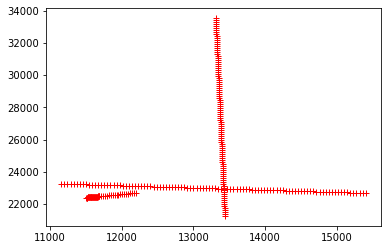

In [46]:
plt.plot(probe_x_list, probe_y_list, 'r+')   

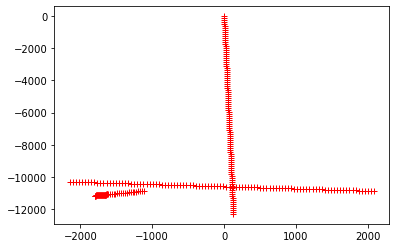

In [47]:
plt.plot(probe_x_centred, probe_y_centred, 'r+')

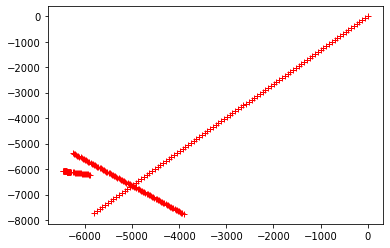

In [48]:
plt.plot(probe_x_rotated, probe_y_rotated, 'r+')

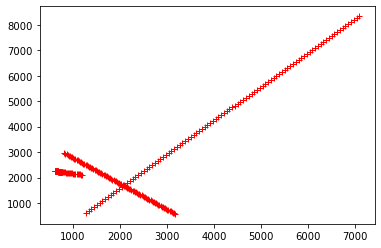

In [49]:
plt.plot(probe_x_placed, probe_y_placed, 'r+')